In [1]:
from google.colab import files

uploaded = files.upload()



Saving Data.csv to Data.csv


In [3]:
!pip install wordcloud

In [0]:
import pandas as pd
import numpy as np
import pickle

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Read The Data

In [0]:
import io

df = pd.read_csv(io.StringIO(uploaded['Data.csv'].decode('utf-8')))

In [6]:
df.head()

,UserId,TweetId,Tweet,ADR_label
0,10030778,413205,Intravenous azithromycin-induced ototoxicity.,1
1,10048291,528244,"Immobilization, while Paget's bone disease was...",1
2,10048291,361834,Unaccountable severe hypercalcemia in a patien...,1
3,10082597,292240,METHODS: We report two cases of pseudoporphyri...,1
4,10082597,467101,METHODS: We report two cases of pseudoporphyri...,1


In [0]:
data = df.copy()

In [8]:
data.shape

(23516, 4)

# Data Cleaning and Text Preprocessing

In [0]:
from bs4 import BeautifulSoup   
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [10]:
!pip install lxml

    100% |████████████████████████████████| 5.8MB 7.1MB/s 


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def tweet_to_words( raw_review ):
    
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    # 3. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # 4. Remove stop words and perform stemming
    
    ps = PorterStemmer()
    meaningful_words = [ps.stem(w) for w in words if not w in set(stops)]  
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [0]:
# Get the number of reviews based on the dataframe column size
num_tweets = data["Tweet"].size

In [14]:
num_tweets

23516

In [15]:

print("Cleaning and parsing the tweets...\n")
clean_tweets = []
for i in range( 0, num_tweets ):
    # If the index is evenly divisible by 50000, print a message
    if( (i+1)%10000 == 0 ):
        print("Review %d of %d\n" % ( i+1, num_tweets )                                                                    )
    clean_tweets.append( tweet_to_words( data["Tweet"][i] ))

Cleaning and parsing the tweets...

Review 10000 of 23516

Review 20000 of 23516



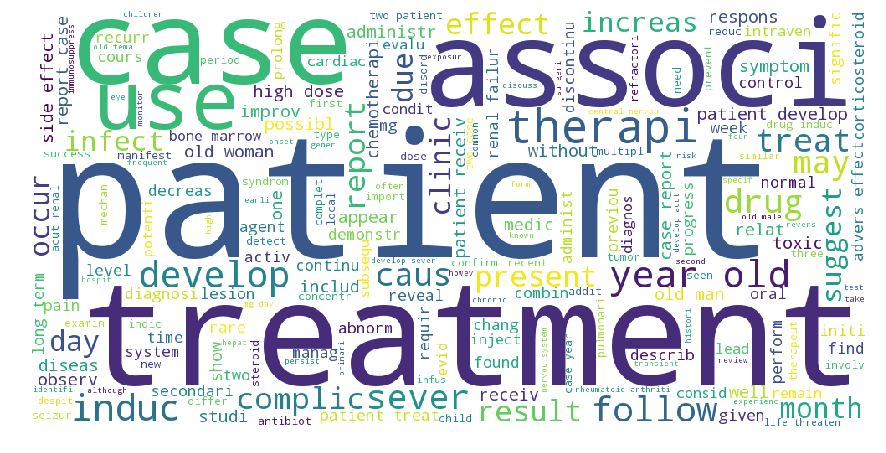

In [16]:
#Plot wordcloud 
wordcloud = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'white').generate(
                        ''.join(clean_tweets))

plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


# Creating the Bag of Words model(Tokenization)

**CountVectorizer bag of words model**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word", max_features = 9000) 

#The input to fit_transform should be a list of strings.
data_features = vectorizer.fit_transform(clean_tweets)

# Numpy arrays are easy to work with, so convert the result to an 
# array
data_features = data_features.toarray()

In [19]:
data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Creating feature matrix and the target variable vector of training **data** **bold text**

In [0]:
X = data_features
y = data['ADR_label'].values

**TFIDF Bag of words Model**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vectorizer_tfidf = TfidfVectorizer(sublinear_tf=True, use_idf =True,max_features = 9000)

data_features_tfidf = vectorizer_tfidf.fit_transform(clean_tweets)

data_features_tfidf = data_features_tfidf.toarray()

In [0]:
X_tfidf = data_features_tfidf
y_tfidf = data['ADR_label'].values

# Model Building

# CountVectorizer based

In [24]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y,stratify=y, test_size = 0.20, random_state = 0)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


***1-Naive Bayes***

In [0]:
from sklearn.naive_bayes import GaussianNB
import seaborn as sb

In [0]:
# Fitting Naive Bayes to the Training set
#from sklearn.naive_bayes import GaussianNB
classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)

# Predicting the Test set results
y_pred_NB = classifier_NB.predict(X_validation)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_validation, y_pred_NB)

In [27]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_validation, y_pred_NB))

0.6358418367346939


**Cross Validation**

In [28]:
from sklearn.model_selection import cross_val_score
accuracies_NB = cross_val_score(estimator = classifier_NB, X = X_train, y = y_train, cv = 5)
accuracies_NB.mean()

0.6432596380748052

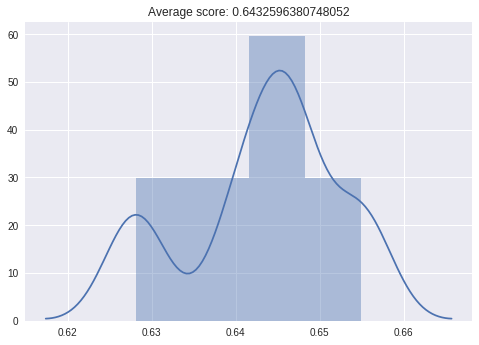

In [31]:
sb.distplot(accuracies_NB)
plt.title('Average score: {}'.format(np.mean(accuracies_NB)))
plt.show()

***2-Random Forest Model***

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
# Initialize a Random Forest classifier with 100 trees
classifier_RF = RandomForestClassifier(n_estimators = 100) 

classifier_RF.fit(X_train, y_train)

# Predicting the Test set results
y_pred_RF = classifier_RF.predict(X_validation)

In [0]:
# Predicting the Test set results
y_pred_RF = classifier_RF.predict(X_validation)

In [35]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_validation, y_pred_RF))

0.8883928571428571


In [36]:
from sklearn.model_selection import cross_val_score
accuracies_RF = cross_val_score(estimator = classifier_RF, X = X_train, y = y_train, cv = 5)
accuracies_RF.mean()

0.8786946489101825

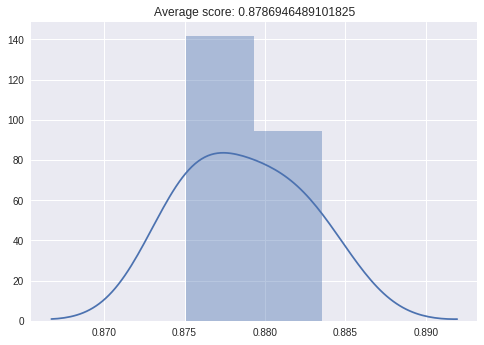

In [37]:
sb.distplot(accuracies_RF)
plt.title('Average score: {}'.format(np.mean(accuracies_RF)))
plt.show()

**3-ANN**

In [38]:
import keras
#Sequence library help us to initialize the NN
from keras.models import Sequential

#Dense library used ti create the Layer of the NN
from keras.layers import Dense

from keras.layers import Dropout
from keras.constraints import maxnorm

Using TensorFlow backend.


In [39]:
# Initialising the ANN
classifier = Sequential()

classifier.add(Dropout(0.25, input_shape=(9000,)))
# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 4500, init = 'uniform', activation = 'relu', kernel_constraint=maxnorm(3)))


# Adding the second hidden layer
classifier.add(Dense(output_dim = 4500, init = 'uniform', activation = 'relu',kernel_constraint=maxnorm(3)))

classifier.add(Dropout(0.25))

classifier.add(Dense(output_dim = 4500, init = 'uniform', activation = 'relu',kernel_constraint=maxnorm(3)))

classifier.add(Dropout(0.25))


# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 1024, nb_epoch = 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", kernel_constraint=<keras.con..., units=4500, kernel_initializer="uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", kernel_constraint=<keras.con..., units=4500, kernel_initializer="uniform")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", kernel_constraint=<keras.con..., units=4500, kernel_initializer="uniform")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_e

Epoch 1/10
18812/18812 [==============================] - 10s 518us/step - loss: 4.4706 - acc: 0.6913
Epoch 2/10
18812/18812 [==============================] - 6s 299us/step - loss: 4.6745 - acc: 0.7099
Epoch 3/10
18812/18812 [==============================] - 6s 300us/step - loss: 4.6742 - acc: 0.7099
Epoch 4/10
18812/18812 [==============================] - 6s 299us/step - loss: 4.6742 - acc: 0.7099
Epoch 5/10
18812/18812 [==============================] - 6s 298us/step - loss: 4.6749 - acc: 0.7099
Epoch 6/10
18812/18812 [==============================] - 6s 299us/step - loss: 4.6756 - acc: 0.7099
Epoch 7/10
18812/18812 [==============================] - 6s 299us/step - loss: 4.6749 - acc: 0.7099
Epoch 8/10
18812/18812 [==============================] - 6s 300us/step - loss: 4.6749 - acc: 0.7099
Epoch 9/10
18812/18812 [==============================] - 6s 300us/step - loss: 4.6742 - acc: 0.7099
Epoch 10/10
18812/18812 [==============================] - 6s 300us/step - loss: 4.6749 - 

In [0]:

# Predicting the Test set results# Predict 
y_pred_ANN = classifier.predict(X_validation)
y_pred_ANN = (y_pred_ANN > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_ANN = confusion_matrix(y_validation, y_pred_ANN)

In [41]:
cm_ANN

array([[3339,    0],
       [1365,    0]])

In [42]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_validation, y_pred_ANN))

0.7098214285714286


# TfidfVectorizer based

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train_tfidf, X_validation_tfidf, y_train_tfidf, y_validation_tfidf = train_test_split(X_tfidf, y_tfidf,stratify=y_tfidf
                                                                                        , test_size = 0.20, random_state = 0)

In [44]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 4551, init = 'uniform', activation = 'relu', input_dim = 9000))

# Adding the second hidden layer
classifier.add(Dense(output_dim = 4551, init = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train_tfidf, y_train_tfidf, batch_size = 1024, nb_epoch = 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9000, units=4551, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=4551, kernel_initializer="uniform")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
18812/18812 [==============================] - 6s 325us/step - loss: 0.5525 - acc: 0.7094
Epoch 2/10
18812/18812 [==============================] - 4s 217us/step - loss: 0.2359 - acc: 0.9099
Epoch 3/10
18812/18812 [==============================] - 4s 217us/step - loss: 0.0684 - acc: 0.9782
Epoch 4/10
18812/18812 [==============================] - 4s 216us/step - loss: 0.0136 - acc: 0.9978
Epoch 5/10
18812/18812 [==============================] - 4s 216us/step - loss: 0.0028 - acc: 0.9997
Epoch 6/10
18812/18812 [==============================] - 4s 215us/step - loss: 9.9610e-04 - acc: 0.9999
Epoch 7/10
18812/18812 [==============================] - 4s 217us/step - loss: 5.3163e-04 - acc: 0.9999
Epoch 8/10
18812/18812 [==============================] - 4s 217us/step - loss: 3.0929e-04 - acc: 1.0000
Epoch 9/10
18812/18812 [==============================] - 4s 217us/step - loss: 2.2280e-04 - acc: 1.0000
Epoch 10/10
18812/18812 [==============================] - 4s 217us/step - 

In [0]:
# Predicting the Test set results
y_pred_ANN_tfidf = classifier.predict(X_validation_tfidf)
y_pred_ANN_tfidf = (y_pred_ANN_tfidf > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_ANN_tfidf = confusion_matrix(y_validation_tfidf, y_pred_ANN_tfidf)


In [46]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_validation, y_pred_ANN_tfidf))

0.9009353741496599


# XGB Classifier

In [47]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier_xg = XGBClassifier()
classifier_xg.fit(X_train_tfidf, y_train_tfidf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [48]:
# calculate accuracy
y_pred_XGB_tfidf = classifier_xg.predict(X_validation_tfidf)
from sklearn import metrics
print(metrics.accuracy_score(y_validation, y_pred_XGB_tfidf))

0.7986819727891157


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**k-Fold Cross Validation**

In [0]:
# from sklearn.model_selection import cross_val_score
# accuracies_XGB = cross_val_score(estimator = classifier_xg, X = X_train_tfidf, y = y_train_tfidf, cv = 5)
# accuracies_XGB.mean()

In [0]:
# sb.distplot(accuracies_XGB)
# plt.title('Average score: {}'.format(np.mean(accuracies_XGB)))
# plt.show()

# Final model - Artificial Neural Network model with tf-idf